In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [24]:
ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

df['XX'] = df['Speed Difference (QuikSCAT - TAO)']/5
df['YY'] = df['Direction Difference (QuikSCAT - TAO)']/50
df['R'] = np.sqrt(df['XX']**2 + df['YY']**2)

df['cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))


for timeWindow in range(20,130,10):
    df[f'cos(Direction Difference (QuikSCAT - TAO {timeWindow} min mean))'] = np.cos(np.deg2rad(df[f'Direction Difference (QuikSCAT - TAO {timeWindow} min mean)']))
    df[f'sin(Direction Difference (QuikSCAT - TAO {timeWindow} min mean))'] = np.sin(np.deg2rad(df[f'Direction Difference (QuikSCAT - TAO {timeWindow} min mean)']))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

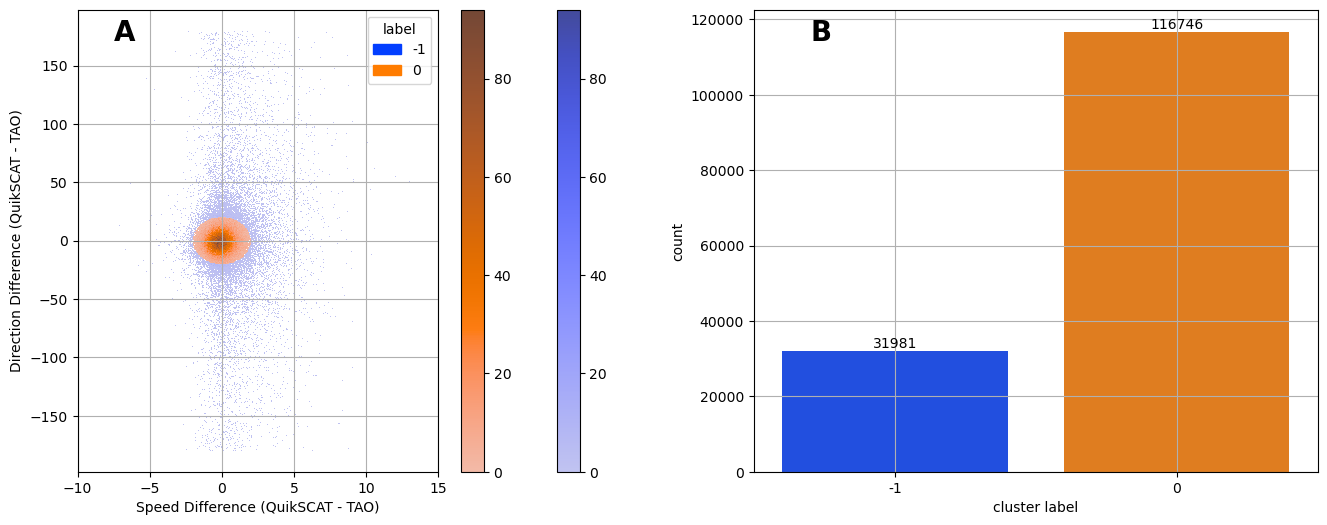

In [25]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

#dbscan = DBSCAN(eps=0.15, min_samples= 500)
mask = df['R'] > 0.4
zeros = np.zeros(len(mask), dtype=int)
zeros[mask] = -1
df['label'] = zeros

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

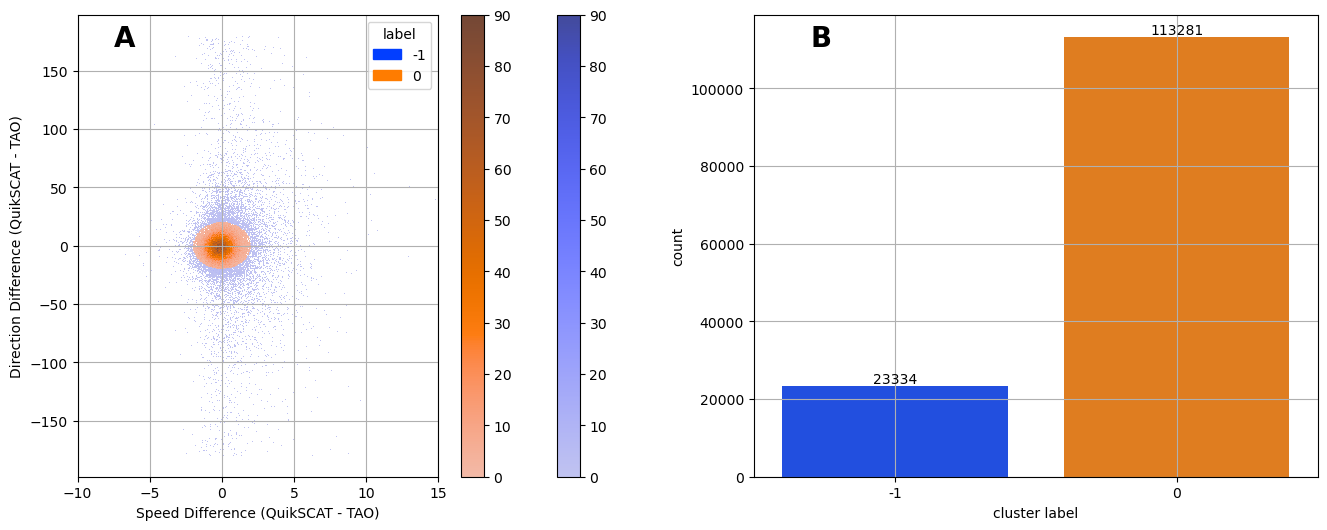

In [26]:
# Create a boolean mask for high wind speeds
highWinds = df['Neutral Wind Speed at 10m (TAO)'] > 3

# Apply the filter correctly using .loc
subDF = df.loc[highWinds]


selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = subDF[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

# dbscan = DBSCAN(eps=0.15, min_samples= 500)
# subDF['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(subDF, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

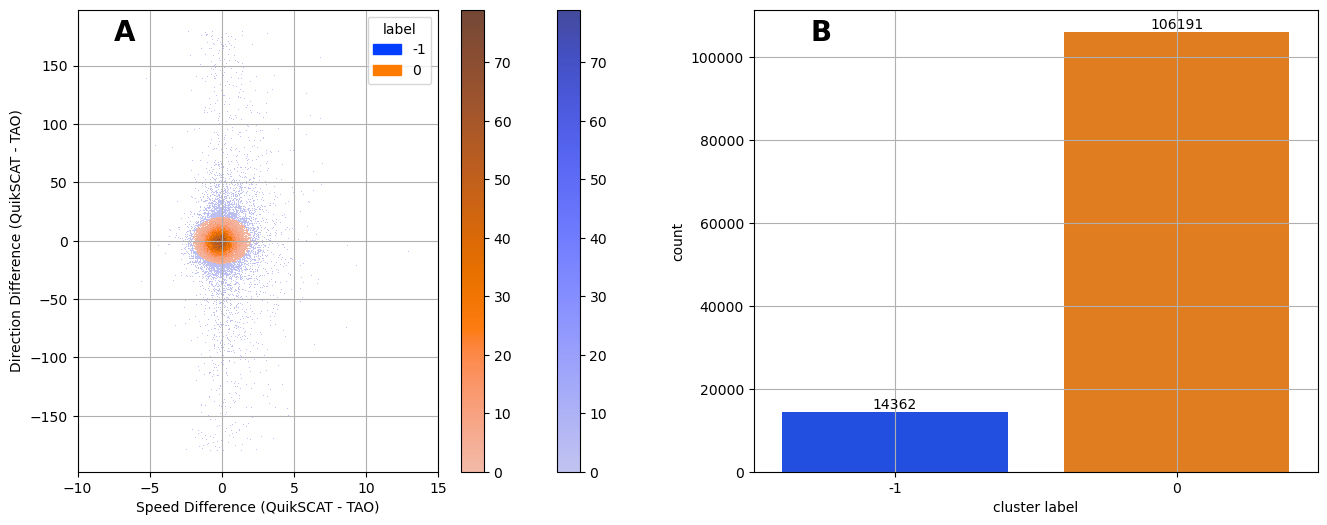

In [27]:
# Create a boolean mask for high wind speeds
highWinds = subDF['std. dev. WSPD_10N 120min'] < 1

# Apply the filter correctly using .loc
subDF = subDF.loc[highWinds]


# Create a boolean mask for high wind speeds
highWinds = subDF['std. dev. sinWDIR 120min'] < 0.2

# Apply the filter correctly using .loc
subDF = subDF.loc[highWinds]


# Create a boolean mask for high wind speeds
highWinds = subDF['std. dev. cosWDIR 120min'] < 0.2

# Apply the filter correctly using .loc
subDF = subDF.loc[highWinds]


selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = subDF[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

# dbscan = DBSCAN(eps=0.15, min_samples= 500)
# subDF['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(subDF, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)


In [28]:
# Filter rows where 'label' is -1
subDF = df.loc[df['label'].isin([-1])]

subDF['sin(Wind Direction (TAO))'] = np.sin(np.deg2rad(subDF['Wind Direction (TAO)']))
subDF['cos(Wind Direction (TAO))'] = np.cos(np.deg2rad(subDF['Wind Direction (TAO)']))

subDF['sin(Wind Direction (QuikSCAT))'] = np.sin(np.deg2rad(subDF['Wind Direction (QuikSCAT)']))
subDF['cos(Wind Direction (QuikSCAT))'] = np.sin(np.deg2rad(subDF['Wind Direction (QuikSCAT)']))

subDF['SST-AIRT'] = subDF['Sea Surface Temperature (TAO)'] - subDF['Air Temperature (TAO)']

/tmp/ipykernel_1243349/1954269976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subDF['sin(Wind Direction (TAO))'] = np.sin(np.deg2rad(subDF['Wind Direction (TAO)']))
/tmp/ipykernel_1243349/1954269976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subDF['cos(Wind Direction (TAO))'] = np.cos(np.deg2rad(subDF['Wind Direction (TAO)']))
/tmp/ipykernel_1243349/1954269976.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [29]:
Xheadings = [ 'SST-AIRT',
             'Relative Humidity (TAO)',
             'Neutral Wind Speed at 10m (TAO)',
             'sin(Wind Direction (TAO))', 
             'cos(Wind Direction (TAO))', 
             'sin(Wind Direction (QuikSCAT))',
             'cos(Wind Direction (QuikSCAT))',
             'std. dev. sinWDIR 120min',
             'std. dev. cosWDIR 120min',
             'std. dev. WSPD_10N 120min']


Yheadings = ['Speed Difference (QuikSCAT - TAO)',
             'cos(Direction Difference (QuikSCAT - TAO))',
             'sin(Direction Difference (QuikSCAT - TAO))']

In [30]:


X = subDF[Xheadings]
Y = subDF[Yheadings]

X = X.rename(columns=lambda x: x.replace(" ", "_"))
Y = Y.rename(columns=lambda x: x.replace(" ", "_"))

In [31]:
Y.head()

,Speed_Difference_(QuikSCAT_-_TAO),cos(Direction_Difference_(QuikSCAT_-_TAO)),sin(Direction_Difference_(QuikSCAT_-_TAO))
count,,,
5,0.660424,0.922598,0.385763
6,0.815122,0.893371,0.449319
9,-0.471795,0.926021,-0.377472
10,0.332083,0.859326,-0.511428
27,1.019817,0.800180,-0.599760


In [32]:



# Generate interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

# Fit regression with interaction terms
model_inter = LinearRegression()
model_inter.fit(X_interactions, Y)

# Extract feature names and coefficients
feature_names = poly.get_feature_names_out(X.columns)
M_inter = model_inter.coef_

# Create DataFrame for interpretation
coef_df_inter = pd.DataFrame(M_inter, columns=feature_names, index=Yheadings)

#tools.display_dataframe_to_user(name="Coefficient Matrix with Interactions", dataframe=coef_df_inter)

from IPython.core.display import display, HTML

# Convert to HTML and display in Jupyter Notebook
display(HTML(coef_df_inter.to_html()))

/tmp/ipykernel_1243349/1015593585.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,SST-AIRT,Relative_Humidity_(TAO),Neutral_Wind_Speed_at_10m_(TAO),sin(Wind_Direction_(TAO)),cos(Wind_Direction_(TAO)),sin(Wind_Direction_(QuikSCAT)),cos(Wind_Direction_(QuikSCAT)),std._dev._sinWDIR_120min,std._dev._cosWDIR_120min,std._dev._WSPD_10N_120min,SST-AIRT Relative_Humidity_(TAO),SST-AIRT Neutral_Wind_Speed_at_10m_(TAO),SST-AIRT sin(Wind_Direction_(TAO)),SST-AIRT cos(Wind_Direction_(TAO)),SST-AIRT sin(Wind_Direction_(QuikSCAT)),SST-AIRT cos(Wind_Direction_(QuikSCAT)),SST-AIRT std._dev._sinWDIR_120min,SST-AIRT std._dev._cosWDIR_120min,SST-AIRT std._dev._WSPD_10N_120min,Relative_Humidity_(TAO) Neutral_Wind_Speed_at_10m_(TAO),Relative_Humidity_(TAO) sin(Wind_Direction_(TAO)),Relative_Humidity_(TAO) cos(Wind_Direction_(TAO)),Relative_Humidity_(TAO) sin(Wind_Direction_(QuikSCAT)),Relative_Humidity_(TAO) cos(Wind_Direction_(QuikSCAT)),Relative_Humidity_(TAO) std._dev._sinWDIR_120min,Relative_Humidity_(TAO) std._dev._cosWDIR_120min,Relative_Humidity_(TAO) std._dev._WSPD_10N_120min,Neutral_Wind_Speed_at_10m_(TAO) sin(Wind_Direction_(TAO)),Neutral_Wind_Speed_at_10m_(TAO) cos(Wind_Direction_(TAO)),Neutral_Wind_Speed_at_10m_(TAO) sin(Wind_Direction_(QuikSCAT)),Neutral_Wind_Speed_at_10m_(TAO) cos(Wind_Direction_(QuikSCAT)),Neutral_Wind_Speed_at_10m_(TAO) std._dev._sinWDIR_120min,Neutral_Wind_Speed_at_10m_(TAO) std._dev._cosWDIR_120min,Neutral_Wind_Speed_at_10m_(TAO) std._dev._WSPD_10N_120min,sin(Wind_Direction_(TAO)) cos(Wind_Direction_(TAO)),sin(Wind_Direction_(TAO)) sin(Wind_Direction_(QuikSCAT)),sin(Wind_Direction_(TAO)) cos(Wind_Direction_(QuikSCAT)),sin(Wind_Direction_(TAO)) std._dev._sinWDIR_120min,sin(Wind_Direction_(TAO)) std._dev._cosWDIR_120min,sin(Wind_Direction_(TAO)) std._dev._WSPD_10N_120min,cos(Wind_Direction_(TAO)) sin(Wind_Direction_(QuikSCAT)),cos(Wind_Direction_(TAO)) cos(Wind_Direction_(QuikSCAT)),cos(Wind_Direction_(TAO)) std._dev._sinWDIR_120min,cos(Wind_Direction_(TAO)) std._dev._cosWDIR_120min,cos(Wind_Direction_(TAO)) std._dev._WSPD_10N_120min,sin(Wind_Direction_(QuikSCAT)) cos(Wind_Direction_(QuikSCAT)),sin(Wind_Direction_(QuikSCAT)) std._dev._sinWDIR_120min,sin(Wind_Direction_(QuikSCAT)) std._dev._cosWDIR_120min,sin(Wind_Direction_(QuikSCAT)) std._dev._WSPD_10N_120min,cos(Wind_Direction_(QuikSCAT)) std._dev._sinWDIR_120min,cos(Wind_Direction_(QuikSCAT)) std._dev._cosWDIR_120min,cos(Wind_Direction_(QuikSCAT)) std._dev._WSPD_10N_120min,std._dev._sinWDIR_120min std._dev._cosWDIR_120min,std._dev._sinWDIR_120min std._dev._WSPD_10N_120min,std._dev._cosWDIR_120min std._dev._WSPD_10N_120min
Speed Difference (QuikSCAT - TAO),-4.490020,-0.020127,0.139277,0.749532,0.602272,0.659982,0.659982,-2.421909,1.315385,3.575892,0.054267,0.020767,0.069983,0.027452,-0.005167,-0.005167,-0.152307,0.725512,-0.136437,-0.001326,-0.010498,-0.012868,-0.005276,-0.005276,0.031408,-0.023507,-0.004936,0.012586,0.103606,-0.061384,-0.061384,0.135030,0.018370,-0.294044,-0.043938,0.014117,0.014117,0.300231,-0.109325,-0.035173,0.110273,0.110273,-0.053603,0.679047,-0.081719,-0.431920,-0.111891,0.017833,0.036562,-0.111891,0.017833,0.036562,1.720326,-0.843333,-0.920923
cos(Direction Difference (QuikSCAT - TAO)),-0.238470,-0.004413,0.046616,0.156165,-0.211431,-0.104074,-0.104074,0.715810,-1.111165,0.055182,0.002116,0.001028,-0.003499,0.008070,0.017392,0.017392,-0.113430,0.144171,0.018625,-0.000152,-0.001901,-0.004115,0.001376,0.001376,-0.004623,0.005182,0.001074,0.009331,0.030623,-0.005749,-0.005749,0.183389,-0.171004,-0.013788,0.047691,0.512102,0.512102,0.108354,-0.071629,-0.009215,0.025960,0.025960,0.127968,-0.057120,0.009533,-0.286665,0.016698,0.000958,-0.012621,0.016698,0.000958,-0.012621,-0.016415,-0.292845,0.087339
sin(Direction Difference (QuikSCAT - TAO)),-0.080019,0.002835,0.052109,-0.120739,-0.016874,0.055965,0.055965,-0.056517,1.251038,-0.055212,0.000581,0.001802,-0.030104,0.003175,-0.000743,-0.000743,0.050301,0.017104,0.006154,-0.000750,0.008058,0.000254,-0.001734,-0.001734,-0.000334,-0.014372,0.000663,-0.011448,-0.007283,0.002267,0.0

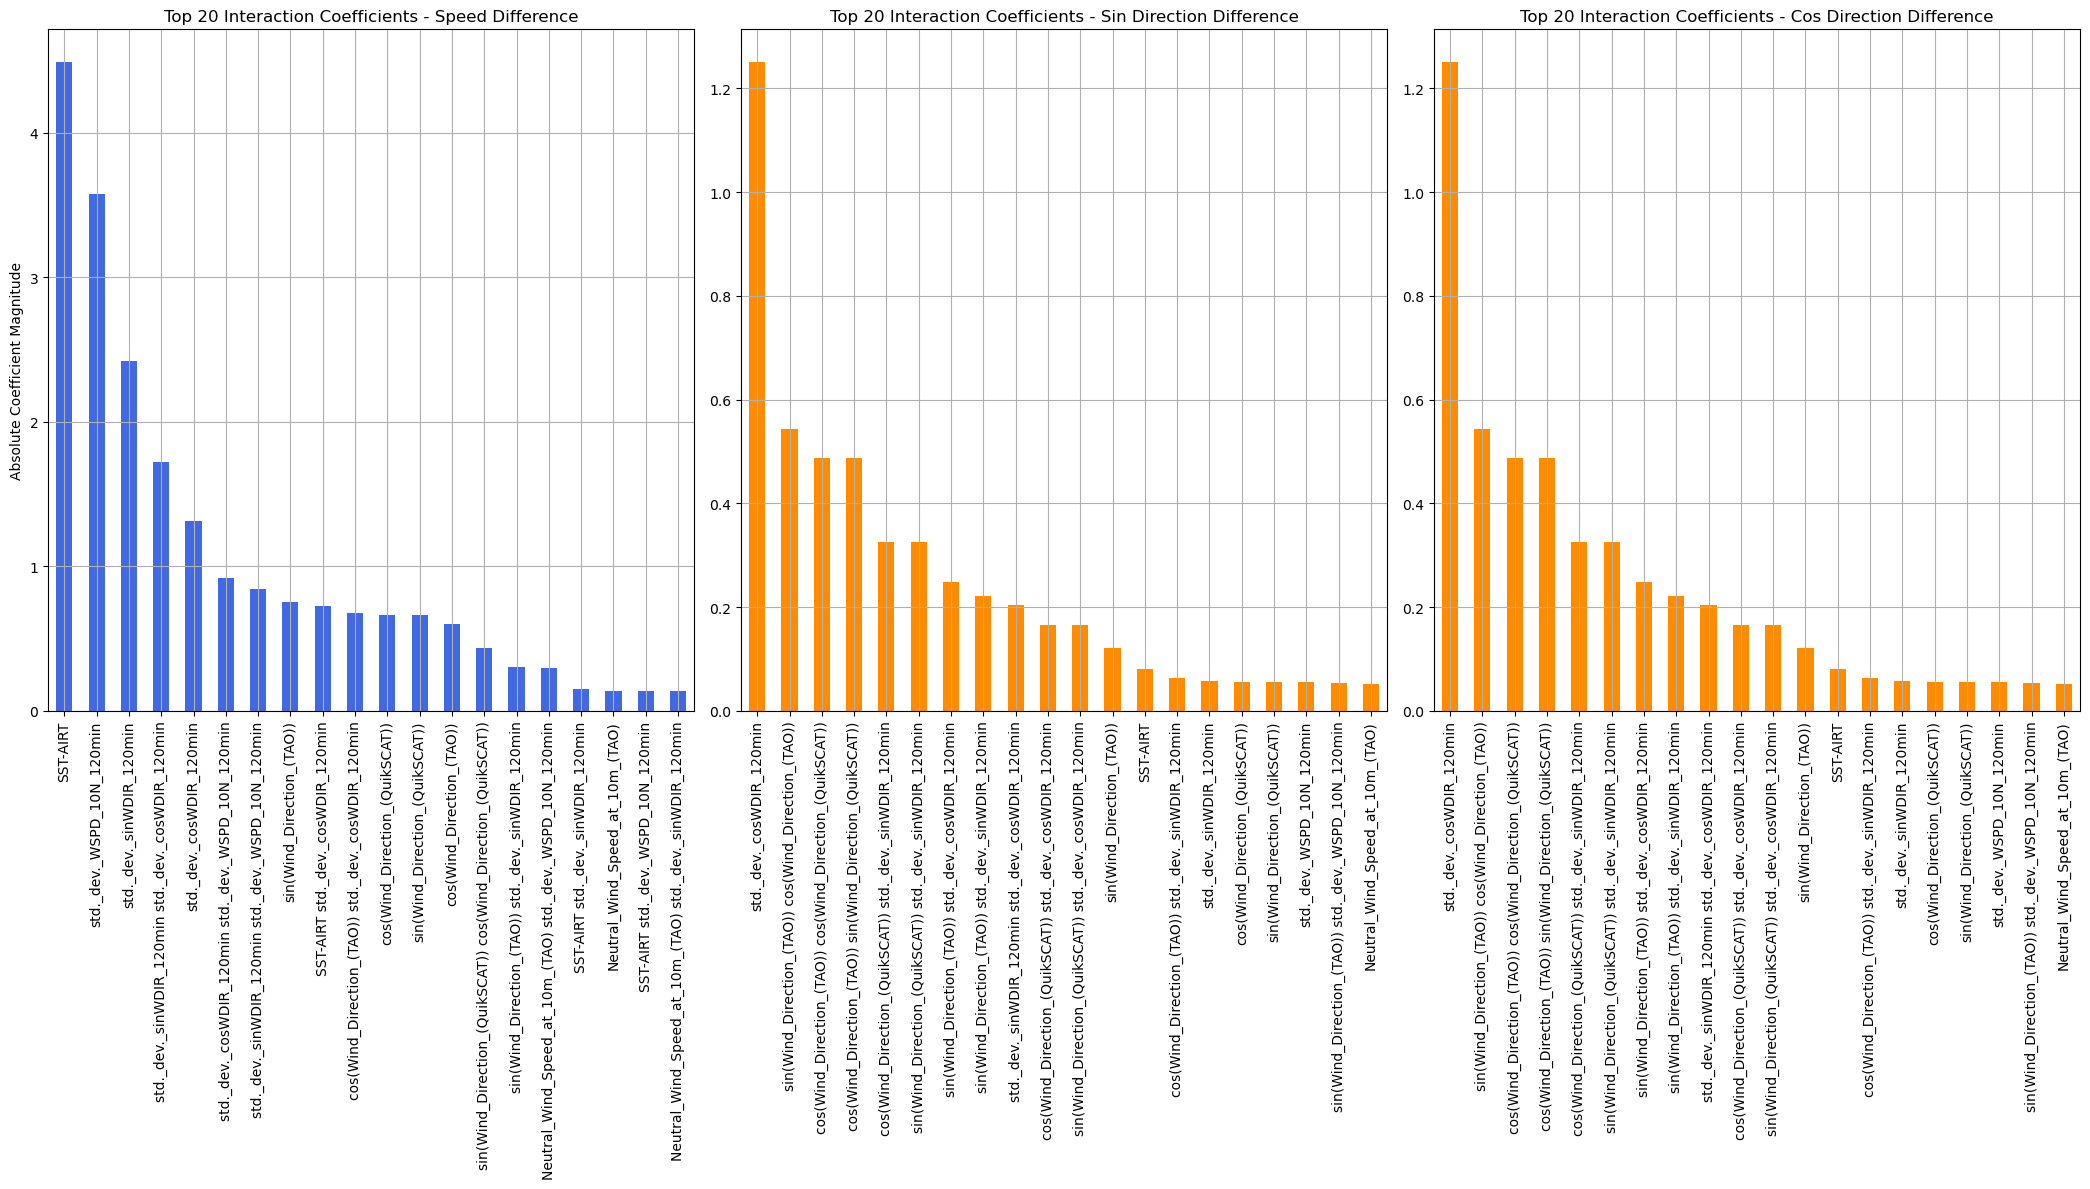

In [33]:
# Extract absolute values and sort separately for Speed Difference and Direction Difference
top_speed_diff = coef_df_inter.loc['Speed Difference (QuikSCAT - TAO)'].abs().sort_values(ascending=False).head(20)
top_cos_direction_diff = coef_df_inter.loc['cos(Direction Difference (QuikSCAT - TAO))'].abs().sort_values(ascending=False).head(20)
top_sin_direction_diff = coef_df_inter.loc['sin(Direction Difference (QuikSCAT - TAO))'].abs().sort_values(ascending=False).head(20)

# Convert to DataFrames for better readability
top_speed_diff_df = pd.DataFrame(top_speed_diff, columns=['Absolute Coefficient Value'])
top_cos_direction_diff_df = pd.DataFrame(top_cos_direction_diff, columns=['Absolute Coefficient Value'])
top_sin_direction_diff_df = pd.DataFrame(top_sin_direction_diff, columns=['Absolute Coefficient Value'])

# Display the top 20 interactions for each target separately
fig, axes = plt.subplots(1, 3, figsize=(21, 12))

# Speed Difference
top_speed_diff.plot(kind='bar', color='royalblue', ax=axes[0])
axes[0].set_title("Top 20 Interaction Coefficients - Speed Difference")
axes[0].set_ylabel("Absolute Coefficient Magnitude")
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid()

# Direction Difference
top_sin_direction_diff.plot(kind='bar', color='darkorange', ax=axes[1])
axes[1].set_title("Top 20 Interaction Coefficients - Sin Direction Difference")
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid()

# Direction Difference
top_sin_direction_diff.plot(kind='bar', color='darkorange', ax=axes[2])
axes[2].set_title("Top 20 Interaction Coefficients - Cos Direction Difference")
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid()

# Show the plots
plt.tight_layout()
plt.show()


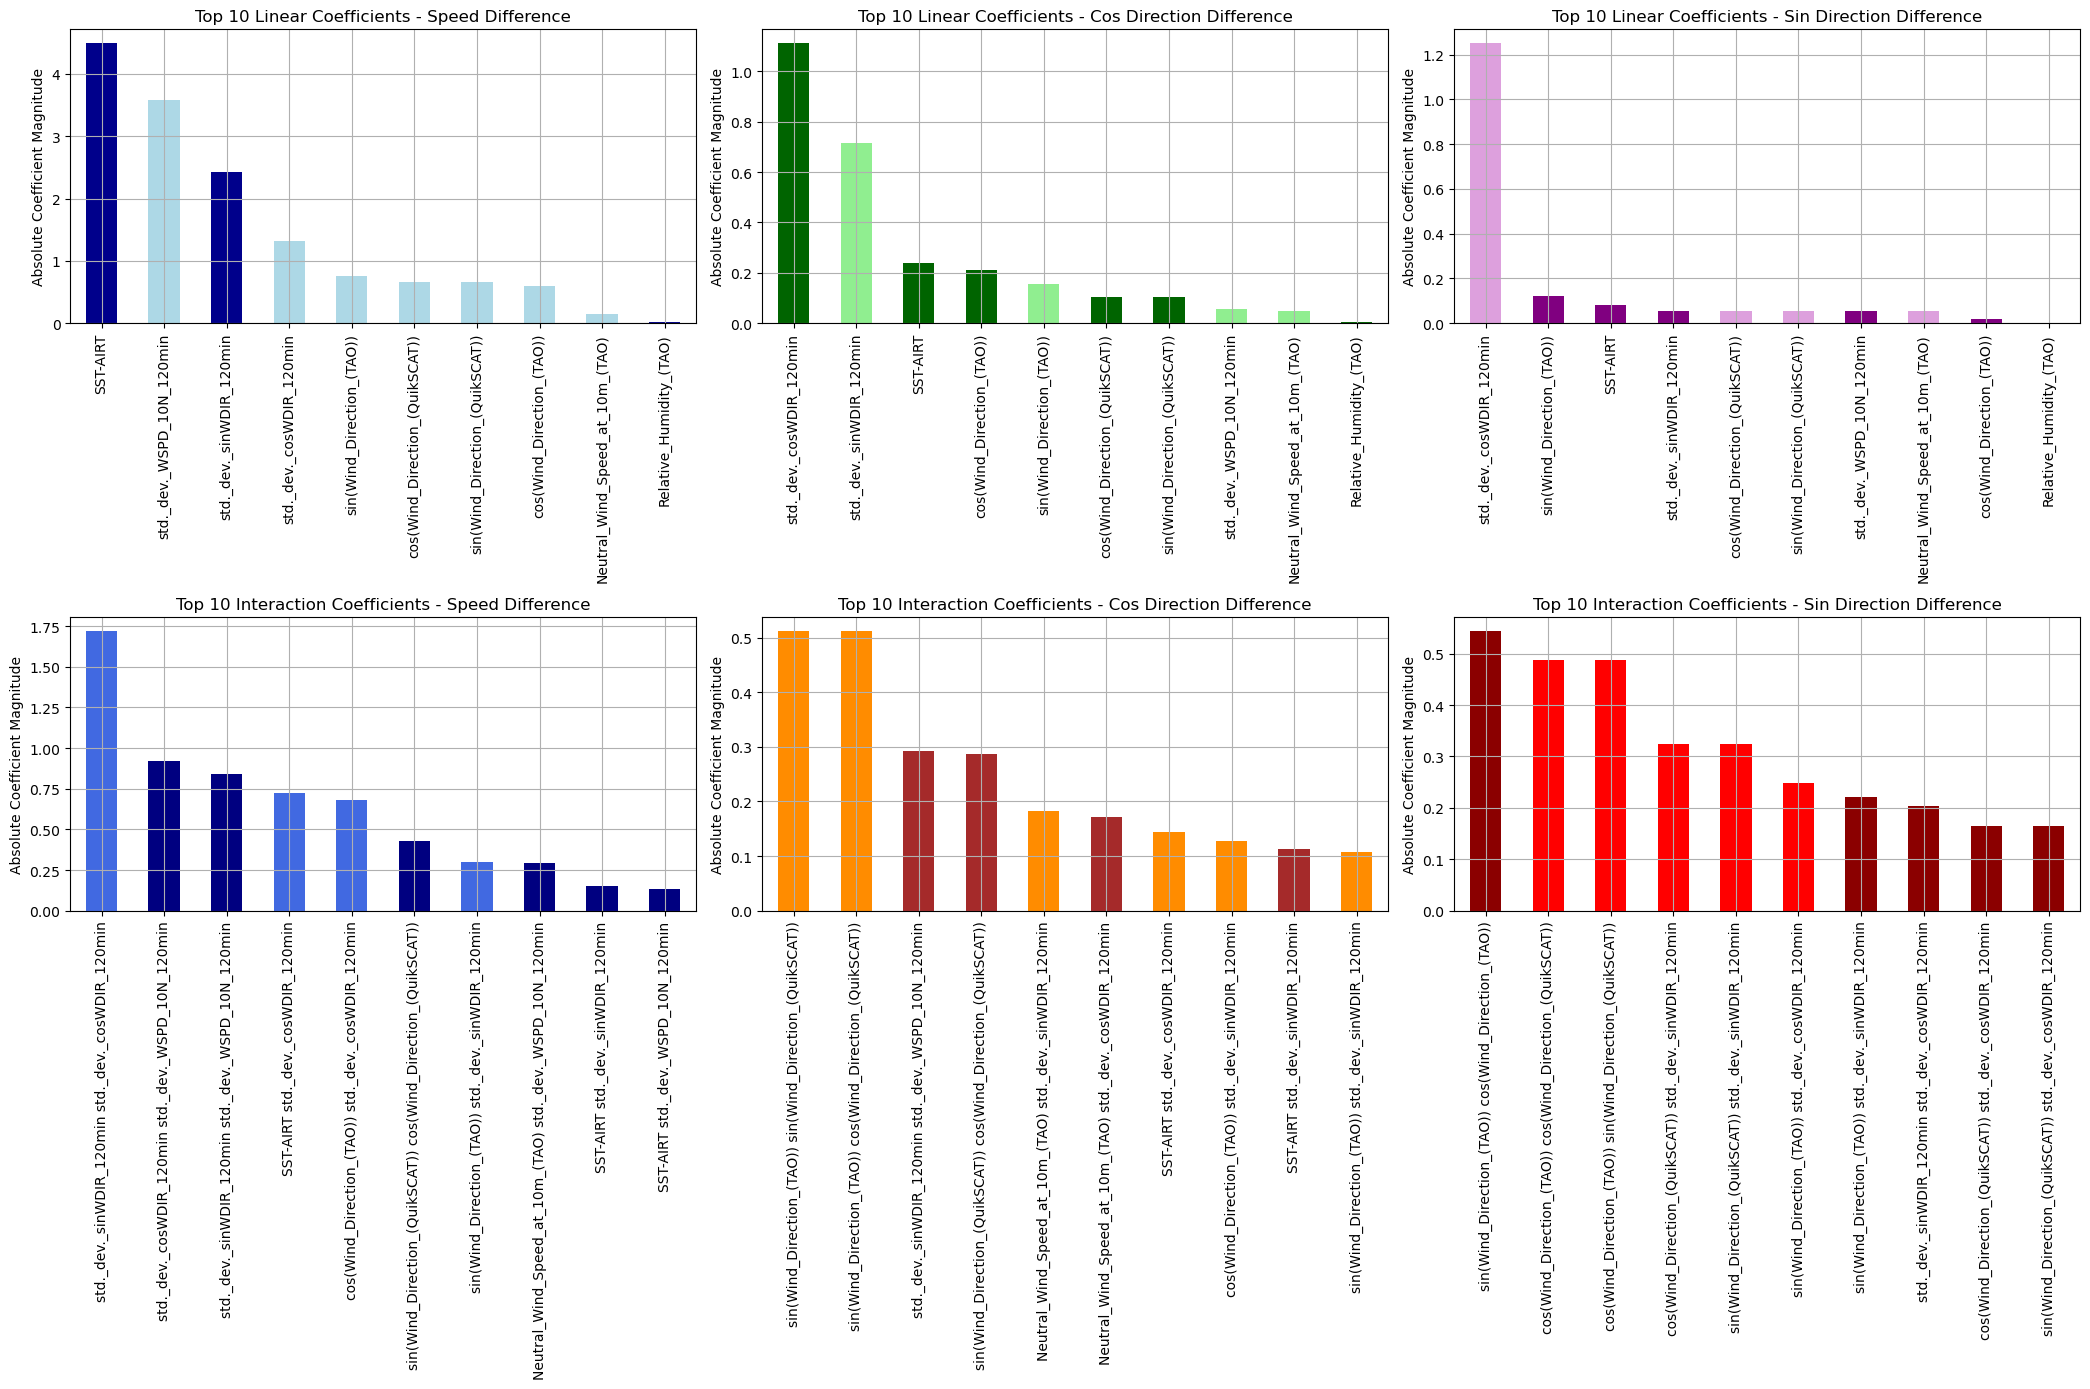

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract absolute values of coefficients
coef_abs = coef_df_inter.abs()

# Identify original features (linear terms)
original_features = list(X.columns)  # Convert set to list

# Separate linear and interaction coefficients
linear_coef_df = coef_df_inter[original_features]  # Keep only linear terms
interaction_coef_df = coef_df_inter.drop(columns=original_features)  # Keep only interaction terms

# Function to plot coefficients with color adjustment for negatives
def plot_coefficients(ax, coef_series, title, light_color, dark_color):
    abs_values = coef_series.abs()  # Plot absolute values
    colors = [dark_color if coef_series[name] < 0 else light_color for name in coef_series.index]
    abs_values.plot(kind='bar', color=colors, ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Absolute Coefficient Magnitude")
    ax.tick_params(axis='x', rotation=90)
    ax.grid()

# Extract top 10 linear coefficients
top_linear_speed_diff = linear_coef_df.loc['Speed Difference (QuikSCAT - TAO)'].sort_values(key=abs, ascending=False).head(10)
top_linear_cos_direction_diff = linear_coef_df.loc['cos(Direction Difference (QuikSCAT - TAO))'].sort_values(key=abs, ascending=False).head(10)
top_linear_sin_direction_diff = linear_coef_df.loc['sin(Direction Difference (QuikSCAT - TAO))'].sort_values(key=abs, ascending=False).head(10)

# Extract top 10 interaction coefficients
top_interaction_speed_diff = interaction_coef_df.loc['Speed Difference (QuikSCAT - TAO)'].sort_values(key=abs, ascending=False).head(10)
top_interaction_cos_direction_diff = interaction_coef_df.loc['cos(Direction Difference (QuikSCAT - TAO))'].sort_values(key=abs, ascending=False).head(10)
top_interaction_sin_direction_diff = interaction_coef_df.loc['sin(Direction Difference (QuikSCAT - TAO))'].sort_values(key=abs, ascending=False).head(10)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(21, 14))

# --- Plot Top 10 Linear Coefficients ---
plot_coefficients(axes[0, 0], top_linear_speed_diff, "Top 10 Linear Coefficients - Speed Difference", "lightblue", "darkblue")
plot_coefficients(axes[0, 1], top_linear_cos_direction_diff, "Top 10 Linear Coefficients - Cos Direction Difference", "lightgreen", "darkgreen")
plot_coefficients(axes[0, 2], top_linear_sin_direction_diff, "Top 10 Linear Coefficients - Sin Direction Difference", "plum", "purple")

# --- Plot Top 10 Interaction Coefficients ---
plot_coefficients(axes[1, 0], top_interaction_speed_diff, "Top 10 Interaction Coefficients - Speed Difference", "royalblue", "navy")
plot_coefficients(axes[1, 1], top_interaction_cos_direction_diff, "Top 10 Interaction Coefficients - Cos Direction Difference", "darkorange", "brown")
plot_coefficients(axes[1, 2], top_interaction_sin_direction_diff, "Top 10 Interaction Coefficients - Sin Direction Difference", "red", "darkred")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


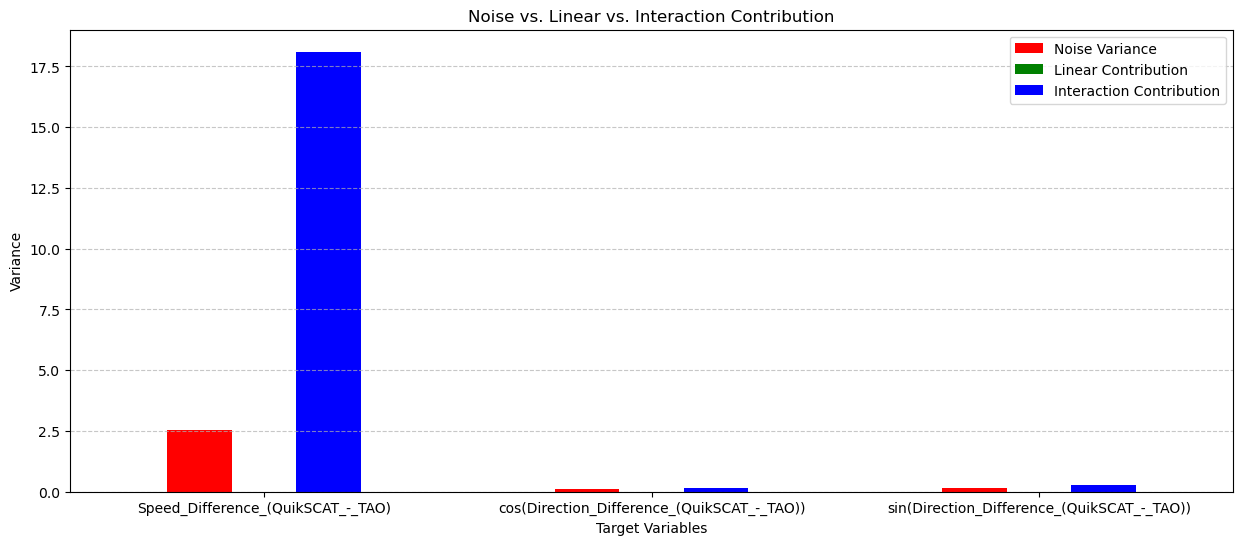

In [35]:
# Identify original feature names
original_features = list(X.columns)  # Convert to list

# Identify interaction terms by excluding original features
interaction_feature_names = [name for name in feature_names if name not in original_features]

# Get the indices of interaction terms in `X_interactions`
interaction_indices = [i for i, name in enumerate(feature_names) if name in interaction_feature_names]

# Extract only interaction terms from `X_interactions`
X_interactions_only = X_interactions[:, interaction_indices]  # Keep only interaction columns

# Extract B (interaction coefficients)
B_df = coef_df_inter[interaction_feature_names]  # Keep only interaction coefficients
B_matrix = B_df.values  # Convert to NumPy array

# Extract A (linear coefficients) from the coefficient matrix
A_df = coef_df_inter[X.columns]  # Keep only linear terms
A_matrix = A_df.values  # Convert to NumPy array

# Compute linear effects contribution
linear_effects = X @ A_matrix.T  # Compute A X
linear_variance = np.var(linear_effects, axis=0)

interaction_effects = X_interactions_only @ B_matrix.T  # Compute B (X x X)
interaction_variance = np.var(interaction_effects, axis=0)

# Predict Y using the regression model with interactions
Y_pred = model_inter.predict(X_interactions)

# Compute residuals (noise)
residuals = Y - Y_pred

# Compute variance of residuals (Noise Contribution)
noise_variance = np.var(residuals, axis=0)  # Compute variance across samples

# Create DataFrame to compare noise, linear, and interaction variances
variance_df = pd.DataFrame({
    "Noise Variance": noise_variance,
    "Linear Variance": linear_variance,
    "Interaction Variance": interaction_variance
}, index=Y.columns)

# Display results
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Noise vs. Linear vs. Interaction Contribution", dataframe=variance_df)

# Plot results
variance_df.plot(kind='bar', figsize=(15, 6), color=['red', 'green', 'blue'])
plt.title("Noise vs. Linear vs. Interaction Contribution")
plt.ylabel("Variance")
plt.xlabel("Target Variables")
plt.xticks(rotation=0)
plt.legend(["Noise Variance", "Linear Contribution", "Interaction Contribution"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

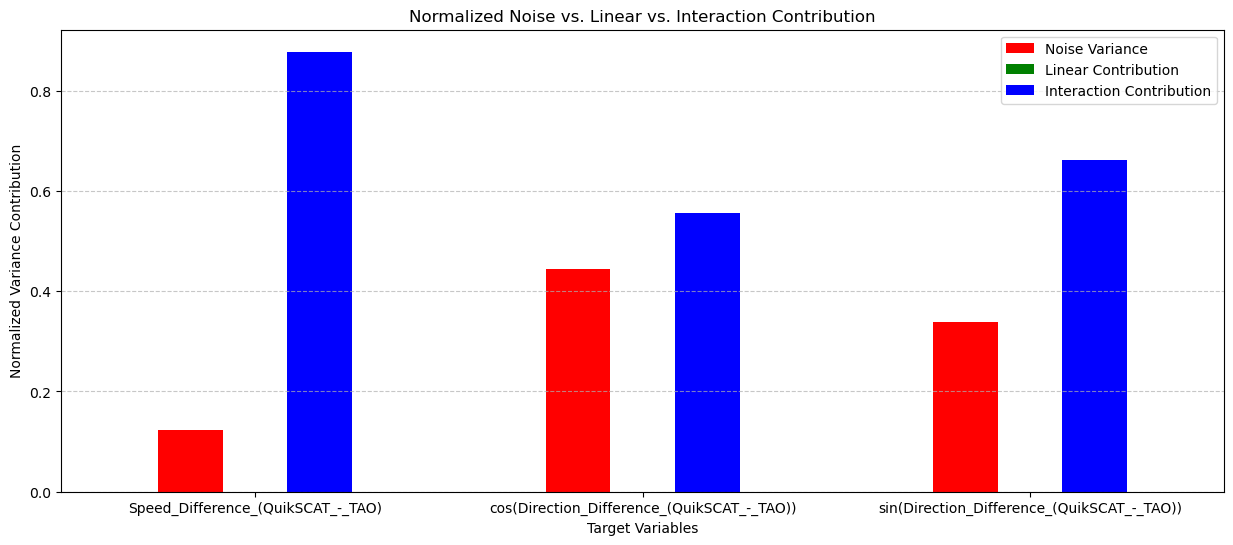

In [36]:
# Normalize the variance so that each column sums to 1
variance_df_normalized = variance_df.div(variance_df.sum(axis=1), axis=0)

# Plot results
variance_df_normalized.plot(kind='bar', figsize=(15, 6), color=['red', 'green', 'blue'])

# Customize the plot
plt.title("Normalized Noise vs. Linear vs. Interaction Contribution")
plt.ylabel("Normalized Variance Contribution")
plt.xlabel("Target Variables")
plt.xticks(rotation=0)
plt.legend(["Noise Variance", "Linear Contribution", "Interaction Contribution"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

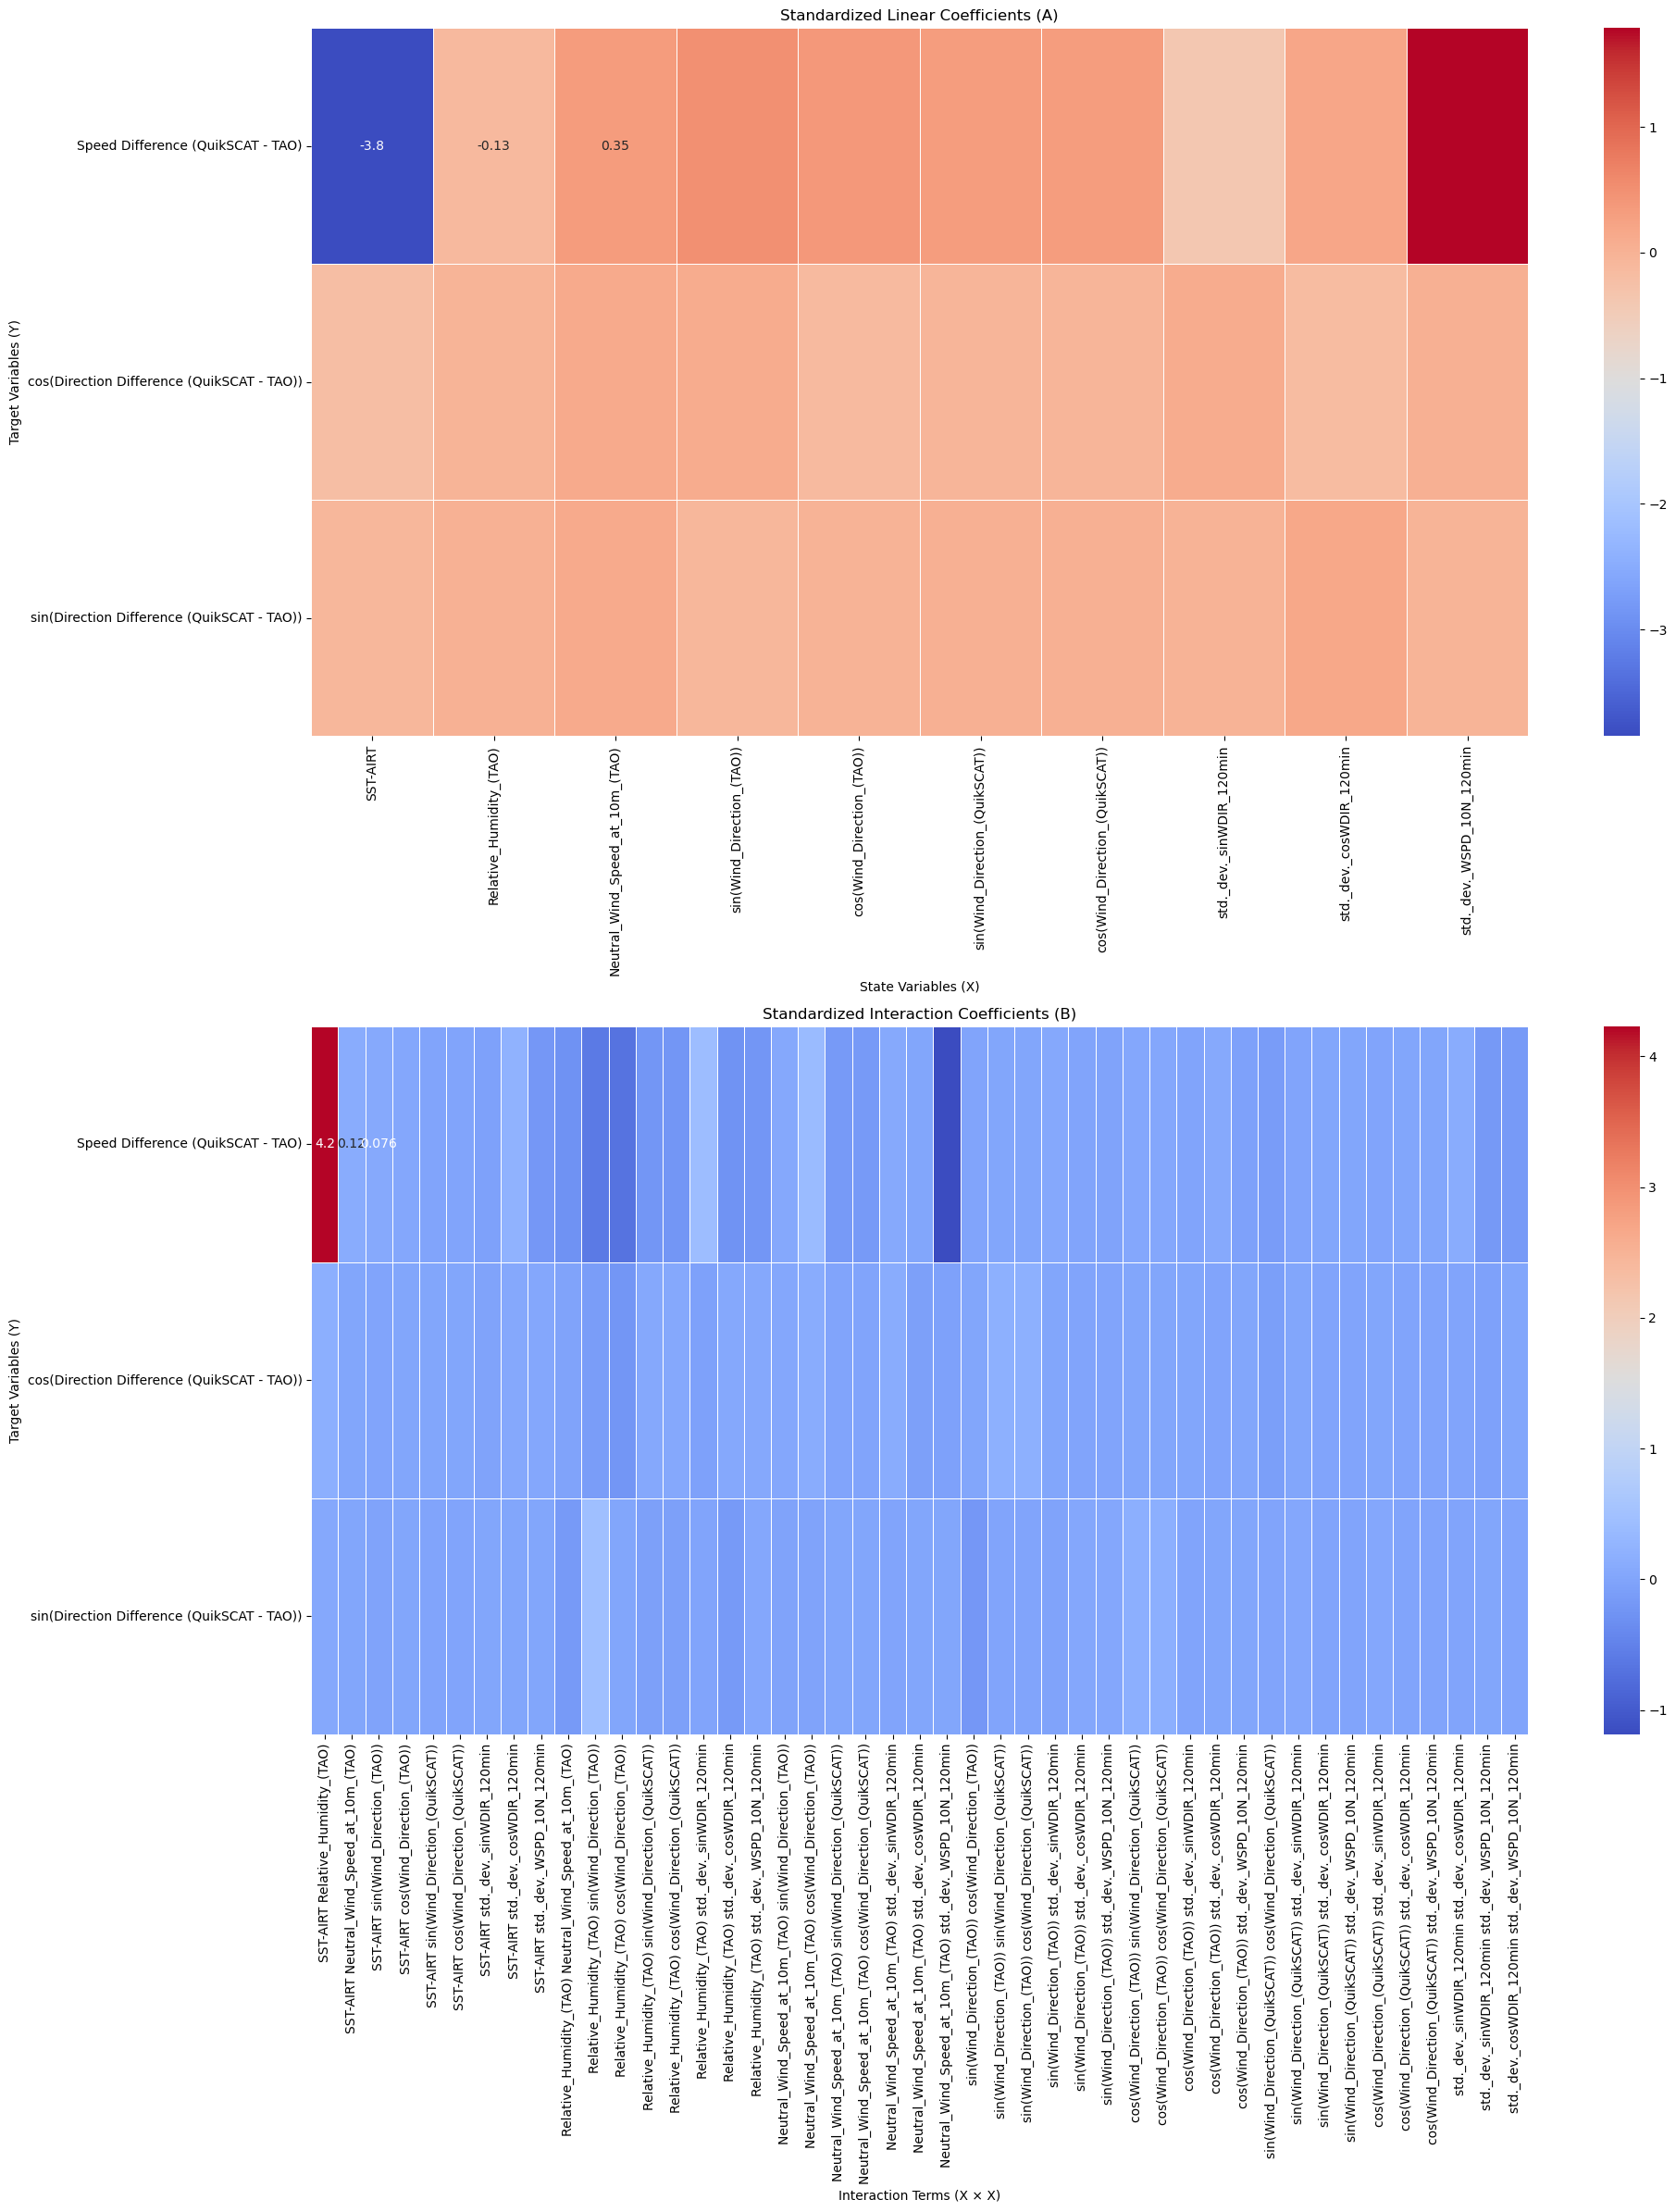

In [37]:
# Compute standardized coefficients (multiply coefficient by feature std dev)
A_std = A_matrix * X.std(axis=0).to_numpy()  # Ensure broadcasting works
B_std = B_matrix * X_interactions_only.std(axis=0)

# Convert to DataFrames using correct row and column names
A_std_df = pd.DataFrame(A_std, columns=X.columns, index=Yheadings)  # Fix row index
B_std_df = pd.DataFrame(B_std, columns=interaction_feature_names, index=Yheadings)  # Fix row index

plt.figure(figsize=(20, 24))

# Plot heatmap for standardized linear coefficients (A_std_df)
plt.subplot(2, 1, 1)
sns.heatmap(A_std_df, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Standardized Linear Coefficients (A)")
plt.xlabel("State Variables (X)")
plt.ylabel("Target Variables (Y)")

# Plot heatmap for standardized interaction coefficients (B_std_df)
plt.subplot(2, 1, 2)
sns.heatmap(B_std_df, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Standardized Interaction Coefficients (B)")
plt.xlabel("Interaction Terms (X × X)")
plt.ylabel("Target Variables (Y)")

# Adjust layout
plt.tight_layout()
plt.show()

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Fit a Random Forest for each Y variable
rf_speed = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cos_direction = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sin_direction = RandomForestRegressor(n_estimators=100, random_state=42)

rf_speed.fit(X, Y.iloc[:, 0])  # Fit to speed difference
rf_cos_direction.fit(X, Y.iloc[:, 1])  # Fit to direction difference
rf_sin_direction.fit(X, Y.iloc[:, 2])  # Fit to direction difference

# Get feature importance
importances_speed = rf_speed.feature_importances_
importances_cos_direction = rf_cos_direction.feature_importances_
importances_sin_direction = rf_sin_direction.feature_importances_

# Create DataFrame for interpretation
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Speed Difference Importance': importances_speed,
    'sin Direction Difference Importance': importances_sin_direction,
    'cos Direction Difference Importance': importances_cos_direction
}).sort_values(by='Speed Difference Importance', ascending=False)

#tools.display_dataframe_to_user(name="Random Forest Feature Importance", dataframe=importance_df)

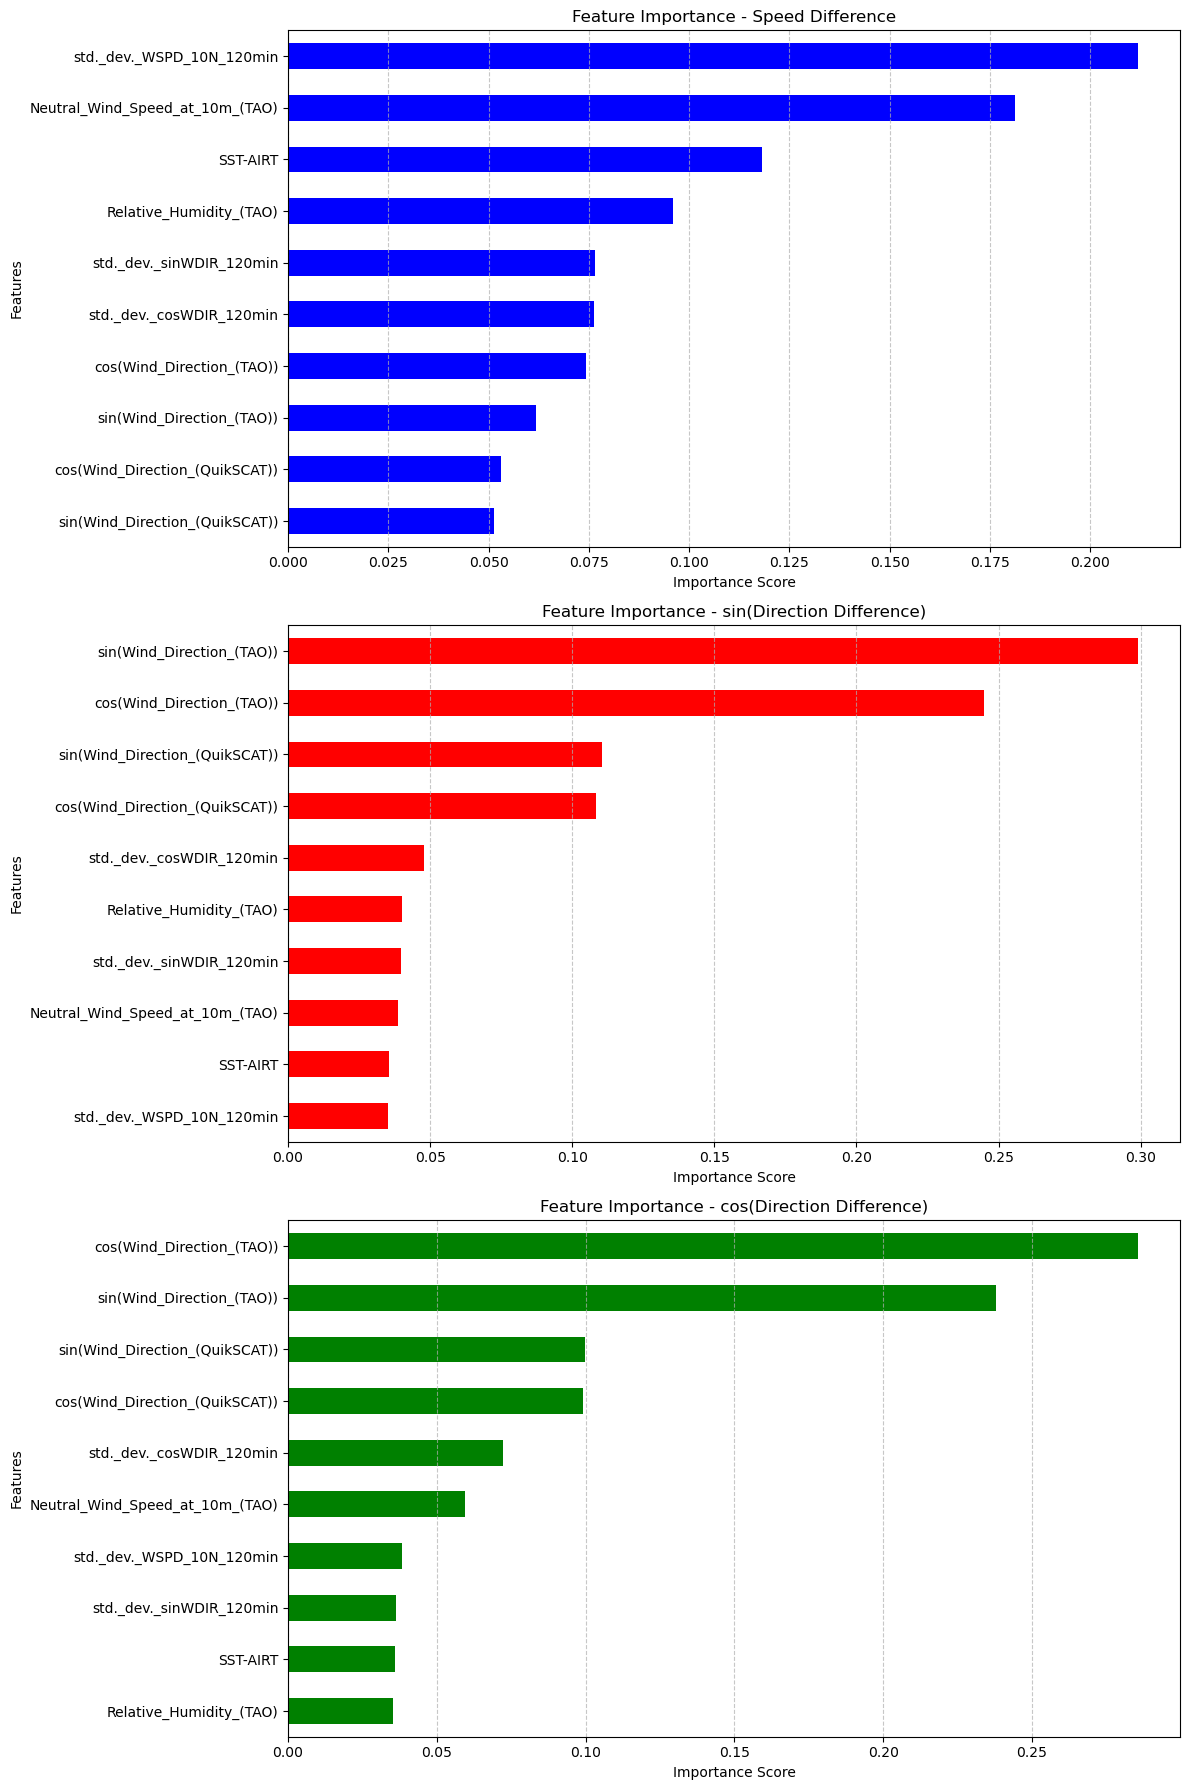

In [39]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Speed Difference Importance': importances_speed,
    'sin Direction Difference Importance': importances_sin_direction,
    'cos Direction Difference Importance': importances_cos_direction
}).set_index('Feature')

# Sort values for better visualization
importance_df_sorted = importance_df.sort_values(by='Speed Difference Importance', ascending=False)

# Plot feature importance for each target variable
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Function to plot horizontal bar charts
def plot_feature_importance(ax, importance_series, title, color):
    importance_series.sort_values().plot(kind='barh', ax=ax, color=color)
    ax.set_title(title)
    ax.set_xlabel("Importance Score")
    ax.set_ylabel("Features")
    ax.grid(axis="x", linestyle="--", alpha=0.7)

# Speed Difference Importance
plot_feature_importance(axes[0], importance_df_sorted['Speed Difference Importance'], 
                        "Feature Importance - Speed Difference", "blue")

# sin(Direction Difference) Importance
plot_feature_importance(axes[1], importance_df_sorted['sin Direction Difference Importance'], 
                        "Feature Importance - sin(Direction Difference)", "red")

# cos(Direction Difference) Importance
plot_feature_importance(axes[2], importance_df_sorted['cos Direction Difference Importance'], 
                        "Feature Importance - cos(Direction Difference)", "green")

# Adjust layout and show plot
plt.tight_layout()
plt.show()